In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [150]:
new_data = pd.read_csv('2022_Jul_5min.csv')
new_data.head()

,TimeStamp,Td,RH
0,timestamp,degC,%
1,2022-07-01 00:05:00,12.04,87.0
2,2022-07-01 00:10:00,12.06,87.0
3,2022-07-01 00:15:00,12.09,87.1
4,2022-07-01 00:20:00,12.08,87.1


In [151]:
# Remove the additional header row and reset the index
new_data = new_data.drop(0).reset_index(drop=True)
# Convert the 'TimeStamp' column to a datetime object
new_data['TimeStamp'] = pd.to_datetime(new_data['TimeStamp'])
# Convert 'Td' and 'RH' columns to numeric types
new_data['Td'] = pd.to_numeric(new_data['Td'])
new_data['RH'] = pd.to_numeric(new_data['RH'])

# Display the cleaned data
new_data.head()


,TimeStamp,Td,RH
0,2022-07-01 00:05:00,12.04,87.0
1,2022-07-01 00:10:00,12.06,87.0
2,2022-07-01 00:15:00,12.09,87.1
3,2022-07-01 00:20:00,12.08,87.1
4,2022-07-01 00:25:00,12.09,87.3


In [152]:
def compute_rh_crit(T, rh_value=70):
    """
    Computes RHcrit based on provided temperature data and given RH value for T > 20.

    Args:
    - T (numpy array): Array of temperature values.
    - rh_value (float): RHcrit value for temperatures greater than 20. Default is 70.

    Returns:
    - rh_crit (numpy array): Array of computed RHcrit values.
    """
    T = np.array(T)
    rh_crit = np.zeros_like(T)
    rh_crit[T <= 20] = -0.0026 * T[T <= 20]**3 + 0.160 * T[T <= 20]**2 - 3.13 + 100.0
    rh_crit[T > 20] = rh_value
    return rh_crit

new_data['RHcrit'] = compute_rh_crit(new_data['Td'])

new_data.head()

,TimeStamp,Td,RH,RHcrit
0,2022-07-01 00:05:00,12.04,87.0,115.525978
1,2022-07-01 00:10:00,12.06,87.0,115.580446
2,2022-07-01 00:15:00,12.09,87.1,115.662248
3,2022-07-01 00:20:00,12.08,87.1,115.634968
4,2022-07-01 00:25:00,12.09,87.3,115.662248


In [153]:
# Define the parameters from the original code
k11 = 1
k12 = 2
A = 1
B = 7
C = 2
p_T = 0.34 # The small parameter suits the 5min data better
p_RH = 6.95 # Divided by 2 more sensitive
p_C = 33.01 # Divided by 2 more sensitive
W = 1
SQ = 1
C_decline = 0.1
t_1 = None

In [154]:
# Initialize an empty arrays for dM/dt and M
dMdt = np.zeros(len(new_data))
M = np.zeros(len(new_data))

# Time in minutes since the start of the dataset
time = np.arange(len(new_data)) * 5  # 5 minutes interval

In [155]:
# Iterate over the new data to compute dM/dt and M
for i in range(len(new_data)):
    # Compute M_max at the current time step
    M_max = A + B * (new_data.loc[i, 'RHcrit'] - new_data.loc[i, 'RH']) / (new_data.loc[i, 'RHcrit'] - 100) - C * ((new_data.loc[i, 'RHcrit'] - new_data.loc[i, 'RH']) / (new_data.loc[i, 'RHcrit'] - 100))**2

    # Compute k1 and k2 at the current time step
    k1 = k11 if M[i-1] < 1 else k12
    k2 = max(1 - np.exp(2.3 * (M[i-1] - M_max)), 0)

    # If this is the start of a period when RH(t) < RHcrit(t), update t_1
    if new_data.loc[i, 'RH'] < new_data.loc[i, 'RHcrit'] and t_1 is None:
        t_1 = time[i]

    # Calculate the time elapsed since t_1 (in hours, because the data is in 5-minute intervals and 1 hour = 60 minutes)
    elapsed_time = (time[i] - t_1) / 60 if t_1 is not None else 0

    # Use the decline model to compute dM/dt when RH(t) < RHcrit(t)
    if new_data.loc[i, 'RH'] < new_data.loc[i, 'RHcrit']:
        if elapsed_time <= 6:
            dMdt[i] = -0.032 * C_decline
        elif elapsed_time <= 24:
            dMdt[i] = 0
        elif elapsed_time > 24:
            dMdt[i] = -0.0016 * C_decline
    else:
        # If RH(t) >= RHcrit(t), compute dM/dt using the given equation and reset t_1
        dMdt[i] = (k1 * k2 / 7) * np.exp(-p_T * np.log(new_data.loc[i, 'Td']) - p_RH * np.log(new_data.loc[i, 'RH']) + 0.14 * W - 0.33 * SQ + p_C)
        t_1 = None

    # Compute M(t) by integrating dM/dt over time
    M[i] = M[i-1] + dMdt[i] if i > 0 else 0

# Add the new dM/dt and M values to the dataframe
new_data['dMdt'] = dMdt
new_data['M'] = M

# Display the first few rows of the data with the computed dM/dt and M columns
new_data.head()


,TimeStamp,Td,RH,RHcrit,dMdt,M
0,2022-07-01 00:05:00,12.04,87.0,115.525978,-0.0032,0.0000
1,2022-07-01 00:10:00,12.06,87.0,115.580446,-0.0032,-0.0032
2,2022-07-01 00:15:00,12.09,87.1,115.662248,-0.0032,-0.0064
3,2022-07-01 00:20:00,12.08,87.1,115.634968,-0.0032,-0.0096
4,2022-07-01 00:25:00,12.09,87.3,115.662248,-0.0032,-0.0128


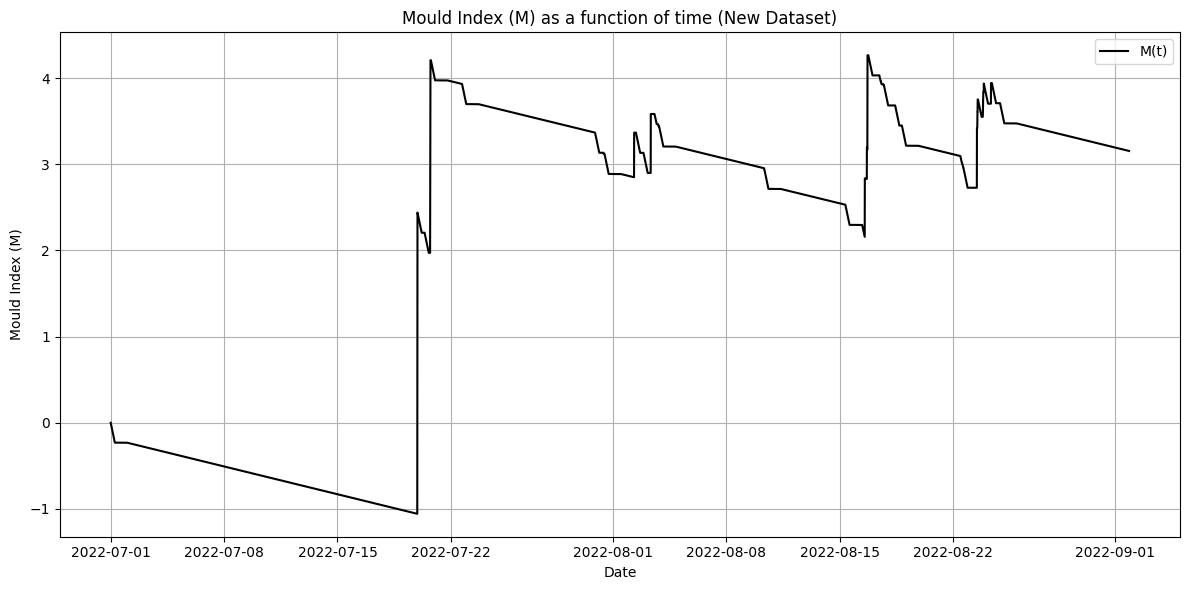

In [156]:
# Plot M as a function of time for the entire new dataset
plt.figure(figsize=(12, 6))
plt.plot(new_data['TimeStamp'], new_data['M'], label='M(t)', color='black')
plt.xlabel('Date')
plt.ylabel('Mould Index (M)')
plt.title('Mould Index (M) as a function of time (New Dataset)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


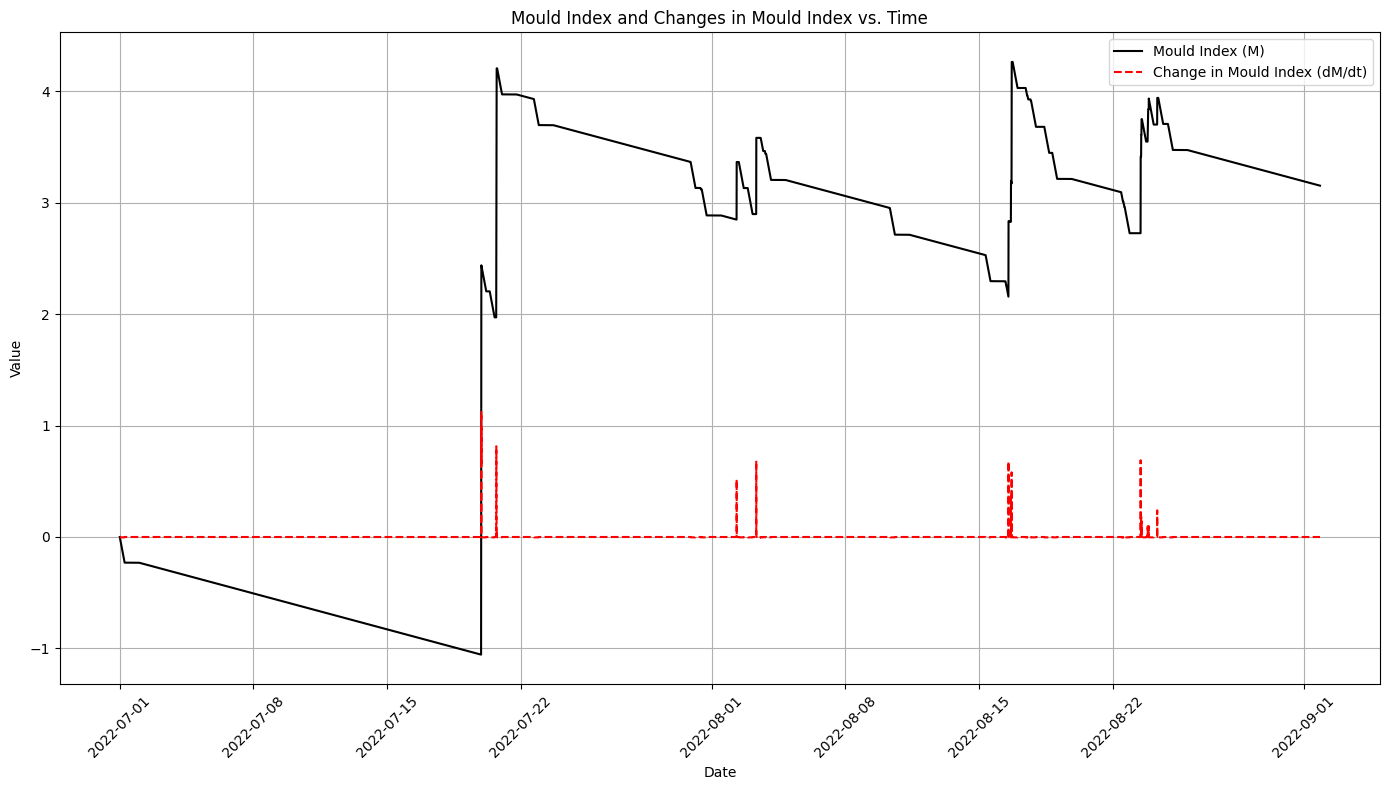

In [157]:
# Plotting Mould Index (M) and changes in the mould index (dM/dt)
plt.figure(figsize=(14, 8))
plt.plot(new_data['TimeStamp'], new_data['M'], label='Mould Index (M)', color='black')
plt.plot(new_data['TimeStamp'], new_data['dMdt'], label='Change in Mould Index (dM/dt)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Mould Index and Changes in Mould Index vs. Time')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [158]:
# Zoom in period of Mould Growth
new_data[(new_data['TimeStamp'] >= '2022-07-20 17:15:59') & (new_data['TimeStamp'] <= '2022-07-22 23:59:59')]

,TimeStamp,Td,RH,RHcrit,dMdt,M
5679,2022-07-20 17:20:00,21.07,78.7,70.000000,0.814652,3.189318
5680,2022-07-20 17:25:00,20.54,82.1,70.000000,0.461999,3.651317
5681,2022-07-20 17:30:00,20.43,84.7,70.000000,0.364137,4.015454
5682,2022-07-20 17:35:00,20.32,85.8,70.000000,0.157788,4.173242
5683,2022-07-20 17:40:00,20.28,85.8,70.000000,0.000000,4.173242
...,...,...,...,...,...,...
6330,2022-07-22 23:35:00,17.99,76.0,133.514474,0.000000,3.698114
6331,2022-07-22 23:40:00,17.94,76.3,133.352903,0.000000,3.698114
6332,2022-07-22 23:45:00,17.76,77.1,132.772093,0.000000,3.698114
6333,2022-07-22 23:50:00,17.57,78.0,132.160527,0.000000,3.698114


Parameter Tunning

In [159]:
def compute_deviation(params, data):
    k11, k12, A, B, C, p_T, p_RH, p_C, W, SQ, C_decline = params
    t_1 = None
    dMdt = np.zeros(len(data))
    M = np.zeros(len(data))
    time = np.arange(len(data)) * 5  # 5 minutes interval

    # Compute M based on the provided parameter set
    for i in range(len(data)):
        M_max = A + B * (data.loc[i, 'RHcrit'] - data.loc[i, 'RH']) / (data.loc[i, 'RHcrit'] - 100) - C * ((data.loc[i, 'RHcrit'] - data.loc[i, 'RH']) / (data.loc[i, 'RHcrit'] - 100))**2
        k1 = k11 if M[i-1] < 1 else k12
        k2 = max(1 - np.exp(2.3 * (M[i-1] - M_max)), 0)
        if data.loc[i, 'RH'] < data.loc[i, 'RHcrit'] and t_1 is None:
            t_1 = time[i]
        elapsed_time = (time[i] - t_1) / 60 if t_1 is not None else 0
        if data.loc[i, 'RH'] < data.loc[i, 'RHcrit']:
            if elapsed_time <= 6:
                dMdt[i] = -0.032 * C_decline
            elif elapsed_time <= 24:
                dMdt[i] = 0
            elif elapsed_time > 24:
                dMdt[i] = -0.0016 * C_decline
        else:
            dMdt[i] = (k1 * k2 / 7) * np.exp(-p_T * np.log(data.loc[i, 'Td']) - p_RH * np.log(data.loc[i, 'RH']) + 0.14 * W - 0.33 * SQ + p_C)
            t_1 = None
        M[i] = M[i-1] + dMdt[i] if i > 0 else 0

    # Compute the deviation of M from the desired range [0,6]
    deviation = np.sum(np.maximum(M - 6, 0)) + np.sum(np.maximum(0 - M, 0))
    return deviation


In [160]:
# Define the two sets of parameters
param_sets = [
    {"p_T": 0.68, "p_RH": 13.9, "p_C": 66.02},
    {"p_T": 0.34, "p_RH": 6.95, "p_C": 33.01}
]

# C_decline values to be tested
C_decline_values = np.arange(0.1, 1.1, 0.1)  # 0.1 to 1 in increments of 0.1

results = []

# Evaluate the model's performance for each parameter set and each C_decline value
for param_set in param_sets:
    for C_decline in C_decline_values:
        deviation = compute_deviation([k11, k12, A, B, C, param_set["p_T"], param_set["p_RH"], param_set["p_C"], W, SQ, C_decline], new_data)
        results.append({
            "p_T": param_set["p_T"],
            "p_RH": param_set["p_RH"],
            "p_C": param_set["p_C"],
            "C_decline": C_decline,
            "deviation": deviation
        })

# Convert into DataFrame for visualization
results_df = pd.DataFrame(results)

# Find the parameter combination with the smallest deviation
best_result = results_df.loc[results_df['deviation'].idxmin()]

best_result


p_T             0.340000
p_RH            6.950000
p_C            33.010000
C_decline       0.100000
deviation    3378.640072
Name: 10, dtype: float64

In [161]:
# compute the deviation with the desired range [0,6] based on different RHcrit values (50-80)
rh_values = [50, 60, 70, 80]
deviations = []

for rh_value in rh_values:
    new_data['RHcrit'] = compute_rh_crit(new_data['Td'], rh_value)
    deviation = compute_deviation([k11, k12, A, B, C, best_result["p_T"], best_result["p_RH"], best_result["p_C"], W, SQ, best_result["C_decline"]], new_data)
    deviations.append(deviation)

deviations

[17860.91366679259, 478.61727999999505, 3378.6400722430544, 3626.636298939887]